In [15]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

I0706 14:33:18.427714 4538740160 <ipython-input-15-bf2b01b18efd>:11] --=logging started=--


In [16]:
import sys
TRAIN = True
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [17]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [18]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [19]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/goil/work


# Imports

In [20]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, seq_labels_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


1.15.2


# Prepare trainset


In [21]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [23]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
#   umtm.export_docs_to_json()
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

I0706 14:35:07.246701 4538740160 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0706 14:35:07.357082 4538740160 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0706 14:35:07.373625 4538740160 retrain_contract_uber_model.py:177] latest export_date: [2020-06-30 22:39:39.571000]
I0706 14:35:07.374460 4538740160 retrain_contract_uber_model.py:179] obtaining DB connection...
I0706 14:35:07.376389 4538740160 retrain_contract_uber_model.py:182] obtaining DB connection: DONE
I0706 14:35:07.379606 4538740160 retrain_contract_uber_model.py:203] running DB query {'$and': [{'parse.documentType': 'CONTRACT'}, {'state': 15}, {'$or': [{'analysis.attributes': {'$ne': None}}, {'user.attributes': {'$ne': None}}]}, {'$or': [{'analysis.analyze_timestamp': {'$gt': Timestamp('2020-06-30 22:39:39.571000')}}, {'user.updateDate': {'$gt': Timestamp('2020-06-30 22:39:39.571000')}}]}]}
I0706 14:35:07.408351 4538740160 retrain_contract_uber_model.py:213] running DB qu

creating ElmoEmbedderImpl instance
< loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
ELMO module loaded >
ELMO: creating embedded_out_elmo
ELMO: embedded_out_defaut embedded_out_elmo


I0706 14:37:25.219604 4538740160 retrain_contract_uber_model.py:283] docs in meta: 609
I0706 14:37:25.292022 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609
I0706 14:37:56.425909 4538740160 retrain_contract_uber_model.py:283] docs in meta: 609
I0706 14:37:56.438714 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609
I0706 14:38:27.058437 4538740160 retrain_contract_uber_model.py:283] docs in meta: 609
I0706 14:38:27.067276 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609
I0706 14:38:39.882942 4538740160 retrain_contract_uber_model.py:283] docs in meta: 609
I0706 14:38:39.889307 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609
I0706 14:40:04.622474 4538740160 retrain_contract_uber_model.py:283] docs in meta: 610
I0706 14:40:04.630210 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 610
I0706 14:40:57.61827

I0706 15:13:35.765373 4538740160 retrain_contract_uber_model.py:283] docs in meta: 647
I0706 15:13:35.775655 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 647
I0706 15:14:32.393999 4538740160 retrain_contract_uber_model.py:283] docs in meta: 648
I0706 15:14:32.402053 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 648
I0706 15:15:30.002950 4538740160 retrain_contract_uber_model.py:283] docs in meta: 649
I0706 15:15:30.012932 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 649
I0706 15:16:25.624300 4538740160 retrain_contract_uber_model.py:283] docs in meta: 650
I0706 15:16:25.632801 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 650
I0706 15:17:57.856800 4538740160 retrain_contract_uber_model.py:283] docs in meta: 651
I0706 15:17:57.862212 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 651
I0706 15:19:16.59352

CursorNotFound: cursor id 6550430488175095723 not found

In [24]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS

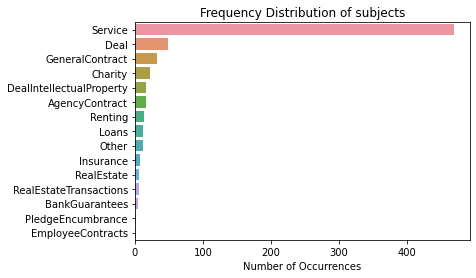


min 2
max 469
total 669


In [25]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [26]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'GeneralContract', 'Service', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'RealEstate', 'Other', 'EmployeeContracts']


Service                     0.357869
Deal                        0.562847
GeneralContract             0.629734
Charity                     0.702241
DealIntellectualProperty    0.777164
AgencyContract              0.777164
Renting                     0.834340
Loans                       0.858446
Other                       0.858446
Insurance                   1.002115
RealEstate                  1.131538
RealEstateTransactions      1.131538
BankGuarantees              1.368099
PledgeEncumbrance           2.004229
EmployeeContracts           2.004229
Name: subject, dtype: float64

I0706 19:49:14.201329 4538740160 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 670
I0706 19:49:14.413780 4538740160 retrain_contract_uber_model.py:283] docs in meta: 670
I0706 19:49:14.421626 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 670


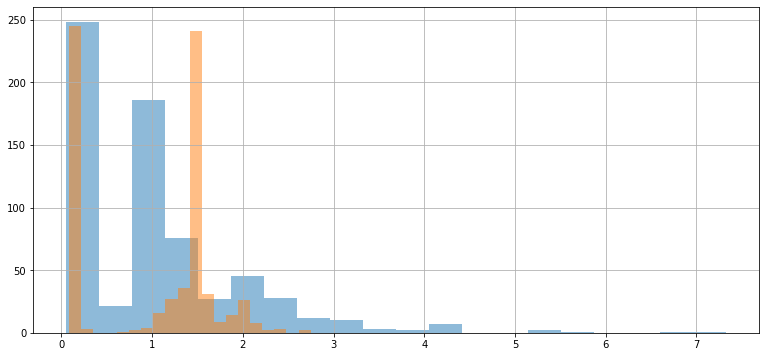

In [28]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  if 'errors' in self.stats:
      self.stats['errors'] = umtm.stats['errors'].fillna(0)
  else:
      self.stats['errors'] = 0
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]

    if 'errors' in row:
      a = float( row['errors'] + 1.0)

#       ## giving more weight to incorrectly analyzed docs
#       subject_weight = subject_weight *(1.0 + row['errors'])
      tagging_weight *= a

    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # NORMALIZE weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20, alpha=0.5)
umtm.stats['sample_weight'].hist(bins=20, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

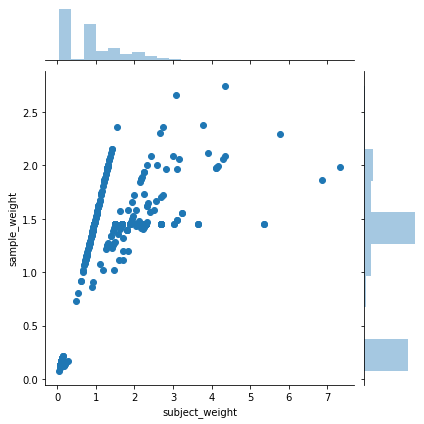

In [29]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.show()


### look into trainset

In [30]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
dp = umtm.make_xyw(SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


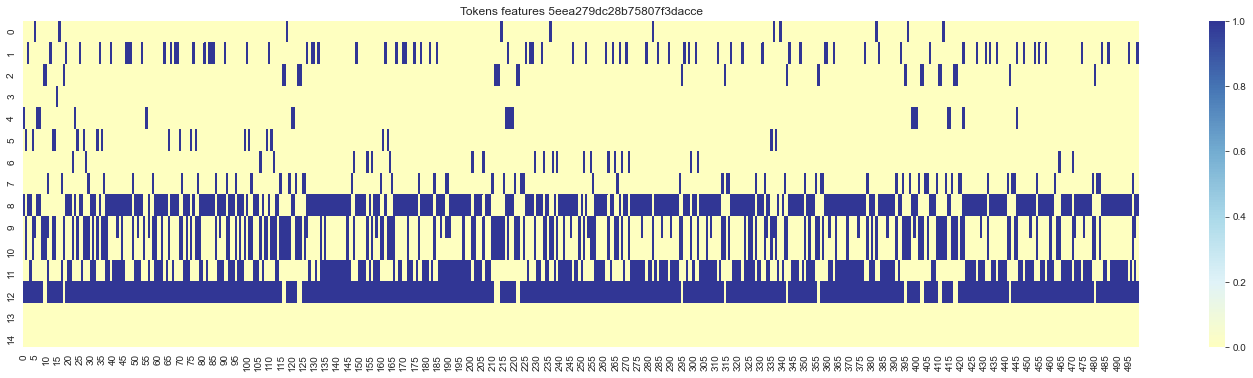

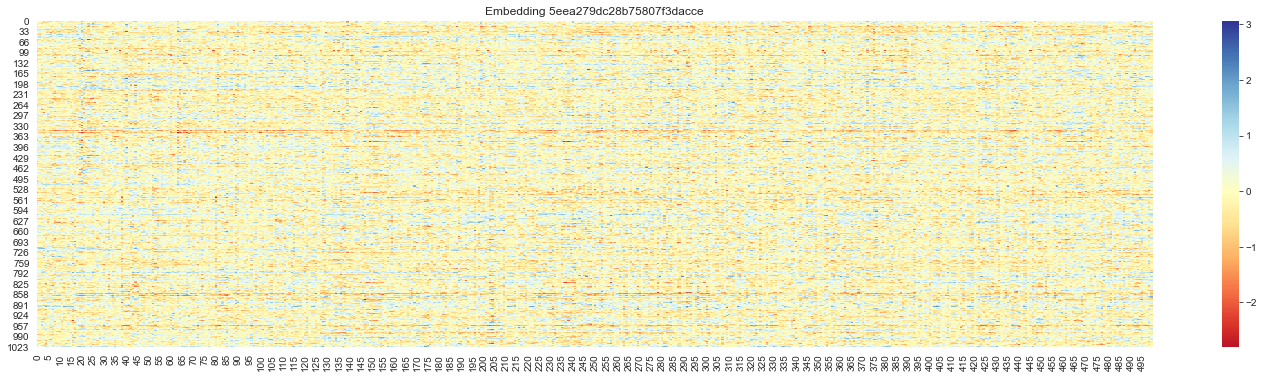

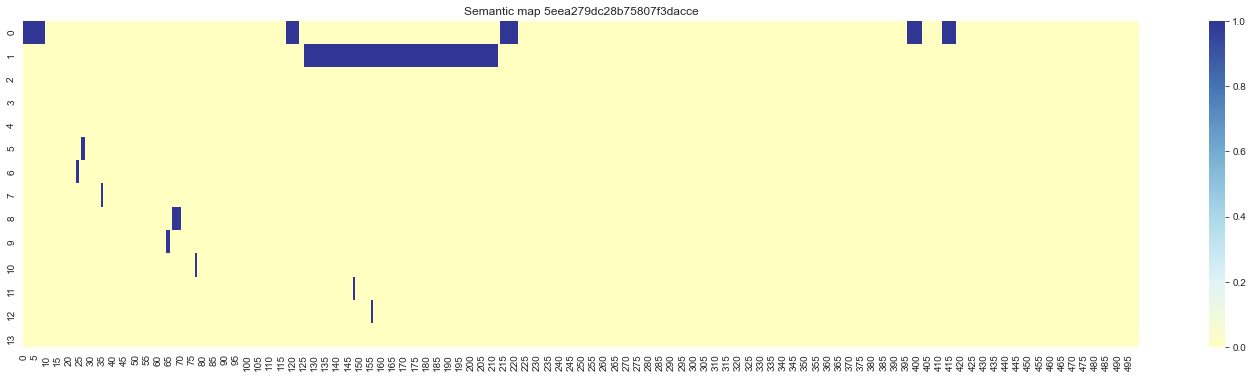

In [31]:
%matplotlib inline

plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [32]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5ee372c52281f29204c525c5
test_indices[0]: 5df620b9200a3f4d0fad777c
X: 2 X[0]= (24, 1176, 1024) X[1]= (24, 1176, 15)
Y: 2 Y[0]= (24, 1176, 14) Y[1]= (24, 43)


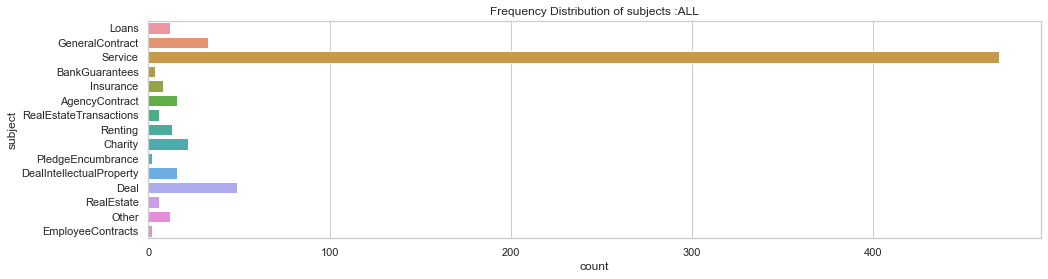

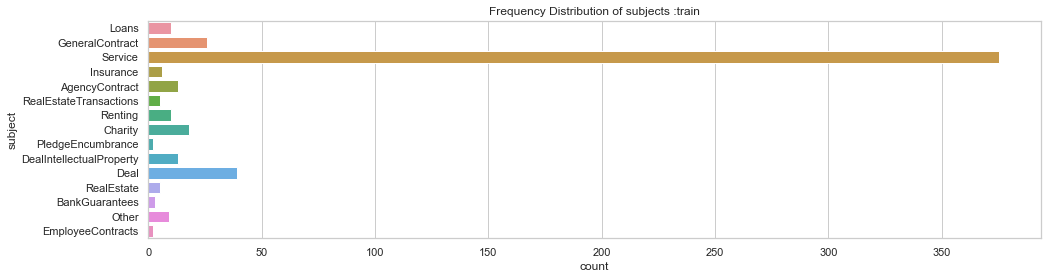

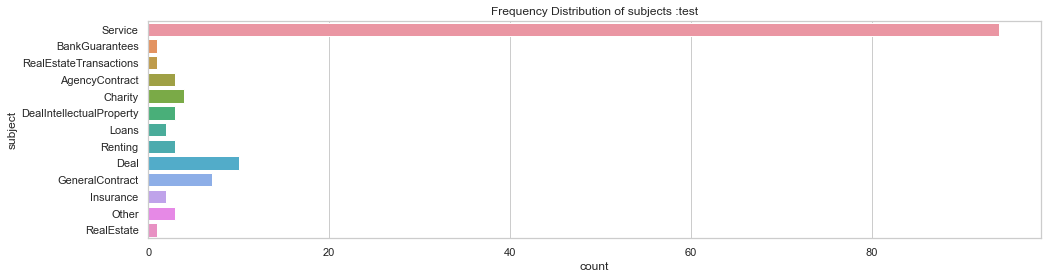

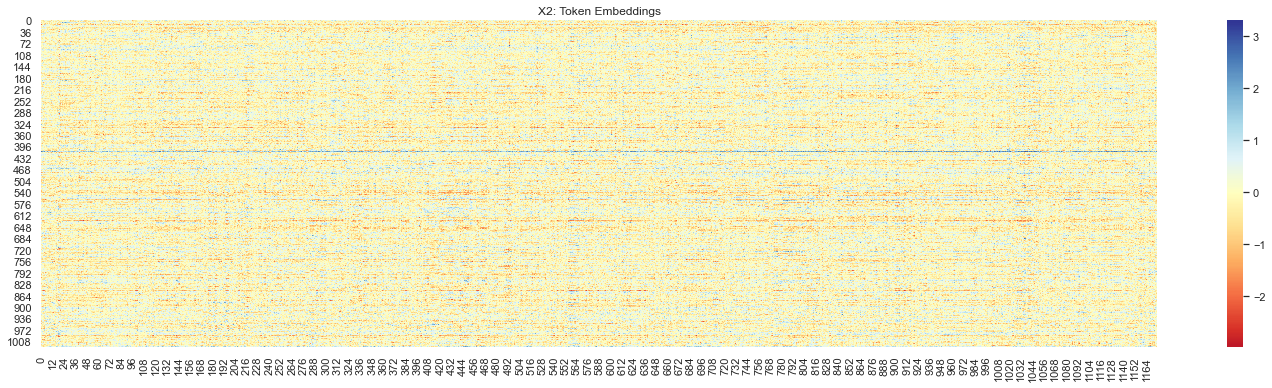

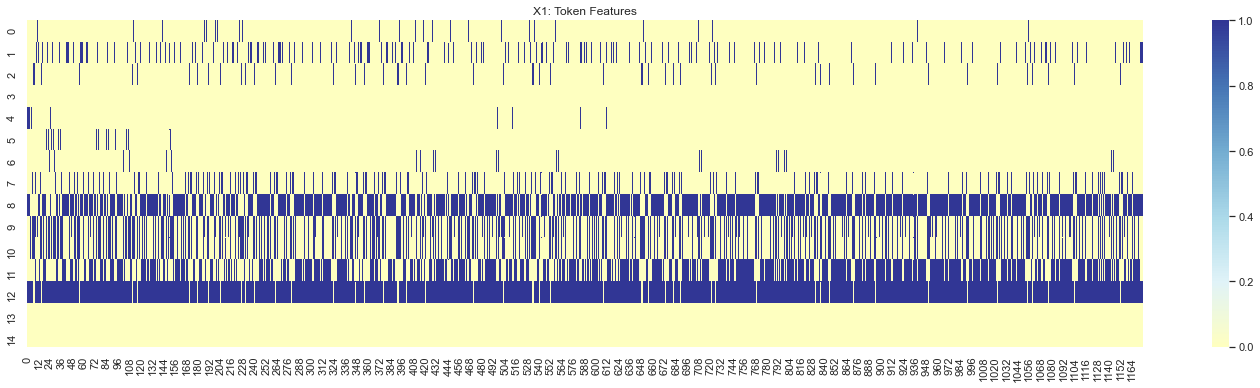

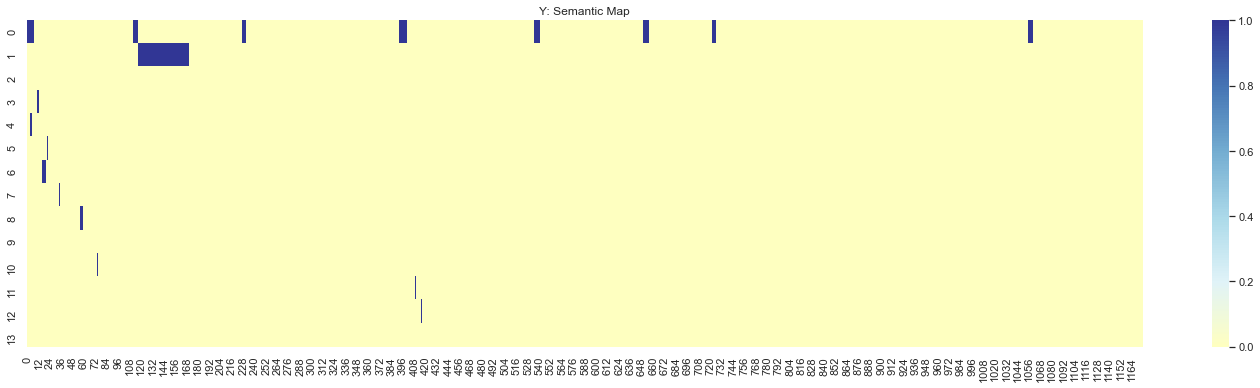

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  del x
  del w
  del y
  del train_gen

In [34]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	2144
test_samples:	134
steps_per_epoch:	89
validation_steps:	44


In [35]:
def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [36]:
umodel = init_model(uber_detection_model_005_1_1)

W0706 19:49:59.026915 4538740160 deprecation.py:506] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0706 19:50:00.011333 4538740160 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

INFO - 2020-07-06 19:50:02,880 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
INFO - 2020-07-06 19:50:02,880 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
I0706 19:50:02.880275 4538740160 <ipython-input-35-

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

In [37]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

model.name == uber_detection_model_005_1_1


W0706 19:50:03.825264 4538740160 deprecation.py:323] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


continue: lr:0.0020000000949949026, epoch:0


W0706 19:50:06.121541 4538740160 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/25
89/89 [==============================] - 179s 2s/step - loss: 0.0130 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0081 - O1_tagging_kullback_leibler_divergence: 0.0340 - O1_tagging_mse: 9.7228e-04 - O1_tagging_binary_crossentropy: 0.0046 - O2_subject_kullback_leibler_divergence: 0.4266 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0163 - val_loss: 0.0133 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0107 - val_O1_tagging_kullback_leibler_divergence: 0.0301 - val_O1_tagging_mse: 7.4278e-04 - val_O1_tagging_binary_crossentropy: 0.0046 - val_O2_subject_kullback_leibler_divergence: 0.1331 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0056

Epoch 00001: val_loss improved from inf to 0.01327, saving model to /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
Epoch 2/25
89/89 [==============================] - 10746s 121s/step - loss: 0.0135 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0082 - O1_tagging_kullback_


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.

Epoch 00011: val_loss did not improve from 0.00817
Epoch 12/25
89/89 [==============================] - 172s 2s/step - loss: 0.0129 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0076 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 9.9387e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_kullback_leibler_divergence: 0.3879 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0149 - val_loss: 0.0246 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0106 - val_O1_tagging_kullback_leibler_divergence: 0.0340 - val_O1_tagging_mse: 7.8272e-04 - val_O1_tagging_binary_crossentropy: 0.0047 - val_O2_subject_kullback_leibler_divergence: 0.1302 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0053

Epoch 00012: val_loss did not improve from 0.00817
Epoch 13/25
89/89 [==============================] - 261s 3s/step - loss: 0.0132 - O1_tagging_loss: 0.0057 - O2


Epoch 00022: val_loss did not improve from 0.00701
Epoch 23/25
89/89 [==============================] - 250s 3s/step - loss: 0.0114 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0061 - O1_tagging_kullback_leibler_divergence: 0.0340 - O1_tagging_mse: 9.4726e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_kullback_leibler_divergence: 0.3940 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0150 - val_loss: 0.0220 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0116 - val_O1_tagging_kullback_leibler_divergence: 0.0316 - val_O1_tagging_mse: 7.8920e-04 - val_O1_tagging_binary_crossentropy: 0.0049 - val_O2_subject_kullback_leibler_divergence: 0.1469 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0057

Epoch 00023: val_loss did not improve from 0.00701
Epoch 24/25
89/89 [==============================] - 258s 3s/step - loss: 0.0109 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0059 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_taggi

In [38]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  umodel.summary()

  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

Epoch 32/50
89/89 [==============================] - 243s 3s/step - loss: 0.0104 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0056 - O1_tagging_kullback_leibler_divergence: 0.0329 - O1_tagging_mse: 9.4975e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_kullback_leibler_divergence: 0.3972 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0150 - val_loss: 0.0061 - val_O1_tagging_loss: 0.0041 - val_O2_subject_loss: 0.0055 - val_O1_tagging_kullback_leibler_divergence: 0.0233 - val_O1_tagging_mse: 6.2393e-04 - val_O1_tagging_binary_crossentropy: 0.0038 - val_O2_subject_kullback_leibler_divergence: 0.0685 - val_O2_subject_mse: 6.6441e-04 - val_O2_subject_binary_crossentropy: 0.0029

Epoch 00032: val_loss did not improve from 0.00431
Epoch 33/50
89/89 [==============================] - 255s 3s/step - loss: 0.0114 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0063 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 9.9070e-04 - O1_tagging_binary_crossentr


Epoch 00042: val_loss did not improve from 0.00431
Epoch 43/50
89/89 [==============================] - 313s 4s/step - loss: 0.0113 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0065 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 9.7044e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.3842 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0146 - val_loss: 0.0114 - val_O1_tagging_loss: 0.0042 - val_O2_subject_loss: 0.0061 - val_O1_tagging_kullback_leibler_divergence: 0.0258 - val_O1_tagging_mse: 6.4745e-04 - val_O1_tagging_binary_crossentropy: 0.0039 - val_O2_subject_kullback_leibler_divergence: 0.0780 - val_O2_subject_mse: 8.1835e-04 - val_O2_subject_binary_crossentropy: 0.0033

Epoch 00043: val_loss did not improve from 0.00431
Epoch 44/50
89/89 [==============================] - 366s 4s/step - loss: 0.0117 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0064 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_t

# Evaluate models

In [39]:
umodel = ctx.init_model(uber_detection_model_005_1_1, trained=True)

weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


### training history

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


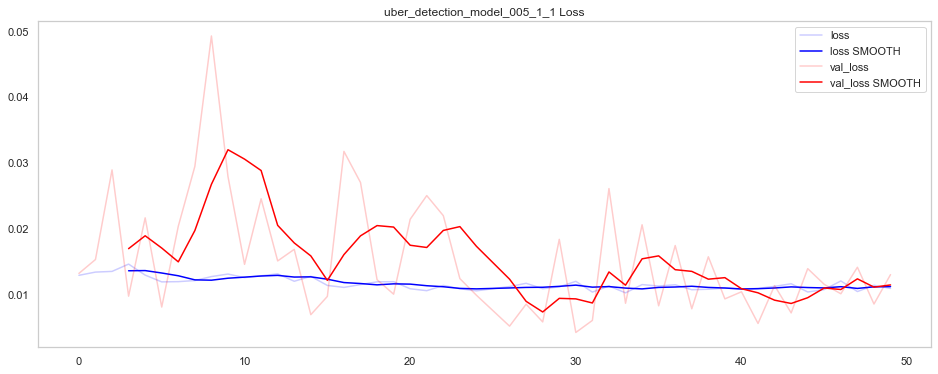

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


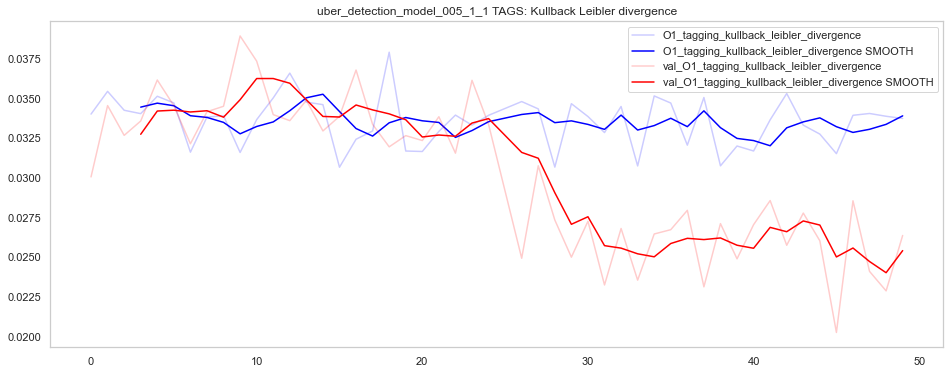

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


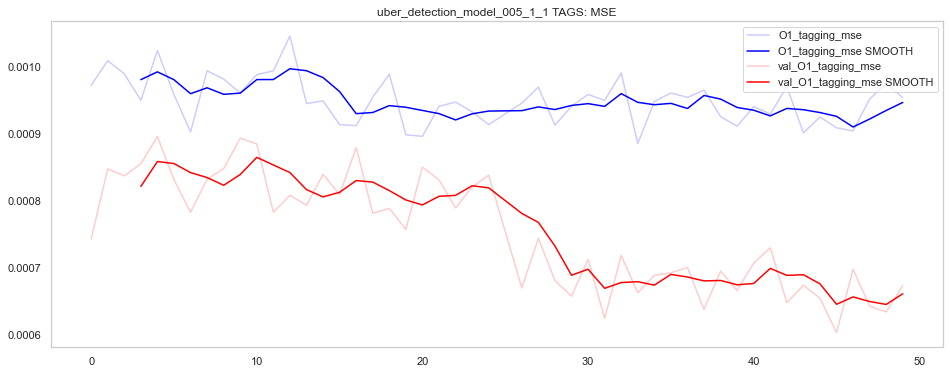

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


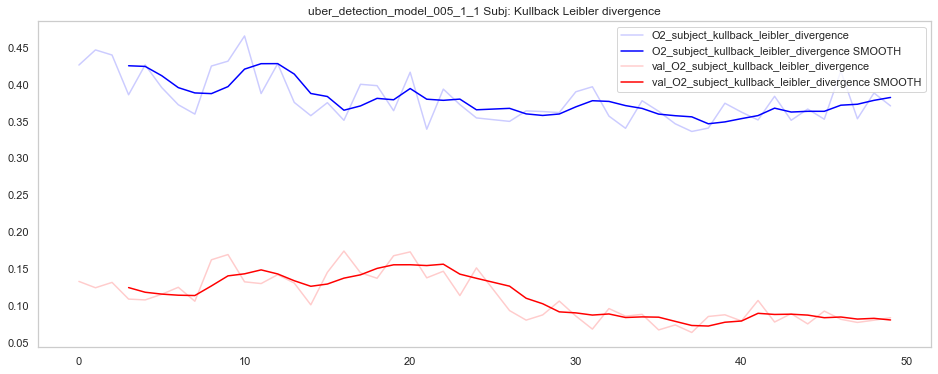

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


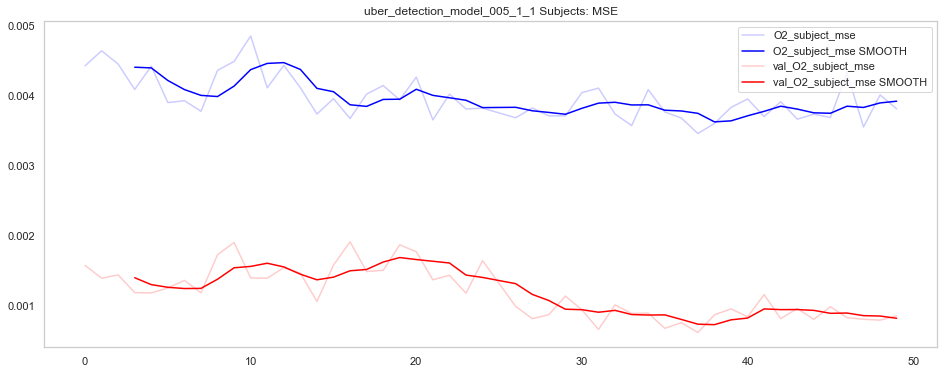

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


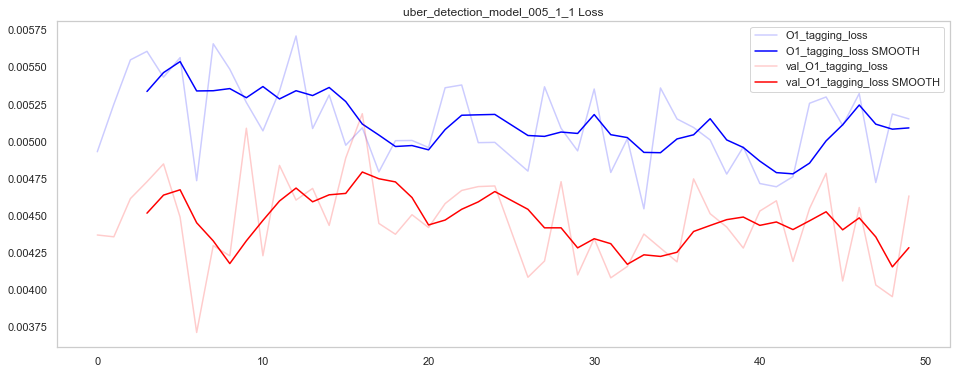

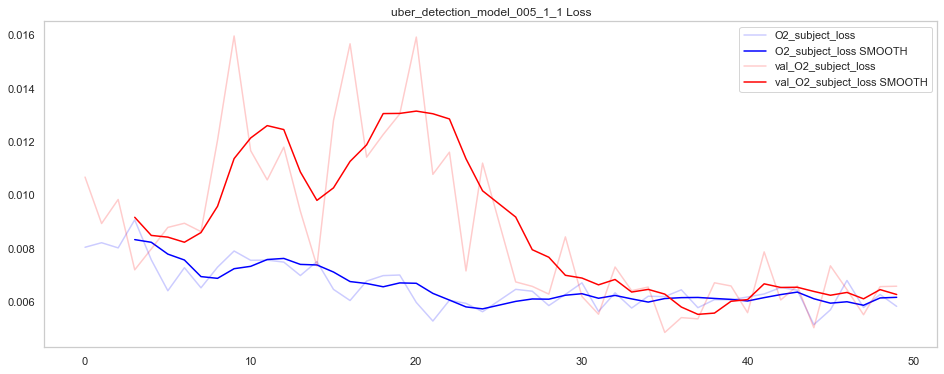

In [40]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [41]:
from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction




def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
  att = tagging[tagname].values
  slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
  if len(slices) > 0:
    span = slices[0].start, slices[0].stop
    value = textmap.text_range(span)
    tag = SemanticTag(tagname, value, span)
    tag.confidence = att[slices[0]].mean()
    return tag
  return None


agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]
tagnames = solo_tags + agent_tags


def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = fetch_tag_value(key, _map, tagsmap)
    results[key] = t
    # print(t)

  ca = ContractAgent()
  ca.name =  results['org-1-name'] #TODO: check for NONE
  ca.type =  results['org-1-type']
  ca.alias = results['org-1-alias']
  normalize_contract_agent(ca)

  ca = ContractAgent()
  ca.name =  results['org-2-name'] #TODO: check for NONE
  ca.type =  results['org-2-type']
  ca.alias = results['org-2-alias']
  normalize_contract_agent(ca)

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]


def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    x, y, _ = umtm.make_xyw(_id)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
    try:
        r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
        put_results_into_df(_id, r, tags, jdoc)
    except:
        # TODO:
        logger.error(f'{_id}')
        pass

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags


subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
ev, tags = make_subj_predictions(umodel, subset.index)
tags.to_csv('all_contracts_predicstions.csv')

I0707 15:10:30.080421 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5deba9034ddc27bcf92dd383 0 of 422
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
I0707 15:10:32.229089 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ded4e284ddc27bcf92dd6ce 1 of 422
I0707 15:10:32.417619 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ded4e294ddc27bcf92dd6d4 2 of 422
I0707 15:10:33.188229 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ded4e294ddc27bcf92dd6d5 3 of 422
I0707 15:10:33.485461 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5df620b9200a3f4d0fad777c 4 of 422
I0707 15:10:34.013134 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5dfa6a938d25a1ac83160bee 5 of 422
I0707 15:10:34.779396 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5dfa6a938d25a1ac83160bf1 6 of 422
I0707 15:10:37.711044 4538740160

I0707 15:11:33.940194 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ed2fce99305fa48fa28b359 70 of 422
I0707 15:11:34.320069 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ed2fcea9305fa48fa28b381 71 of 422
I0707 15:11:35.659869 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee190fb2281f29204c522f7 72 of 422
I0707 15:11:36.149519 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee8c456c28b75807f3dabe1 73 of 422
I0707 15:11:37.034045 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee8c456c28b75807f3dabe2 74 of 422
I0707 15:11:38.048317 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee8c456c28b75807f3dabe3 75 of 422
I0707 15:11:39.389519 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee8c456c28b75807f3dabe4 76 of 422
I0707 15:11:40.998494 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee8c456c28b75807f3dabe5 77 of 422
I0707 15:11:42.353222 4538740160 <ipython-input-41-bea9c4b76f2e>:128] va

I0707 15:12:40.175117 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbadd9da3678279fbcaaff 141 of 422
I0707 15:12:41.132991 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59cda3678279fbcac7d 142 of 422
I0707 15:12:41.435884 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59cda3678279fbcac89 143 of 422
I0707 15:12:41.750679 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59dda3678279fbcac8b 144 of 422
I0707 15:12:42.529255 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59eda3678279fbcac9f 145 of 422
I0707 15:12:43.168874 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59eda3678279fbcaca1 146 of 422
I0707 15:12:43.452366 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59eda3678279fbcaca2 147 of 422
I0707 15:12:43.727344 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc59eda3678279fbcacae 148 of 422
I0707 15:12:44.581717 4538740160 <ipython-input-41-bea9c4b76f2e>

I0707 15:13:45.127954 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc667da3678279fbcaf52 212 of 422
I0707 15:13:45.774475 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc667da3678279fbcaf53 213 of 422
I0707 15:13:46.483535 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc667da3678279fbcaf65 214 of 422
I0707 15:13:49.480036 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc668da3678279fbcaf6e 215 of 422
I0707 15:13:50.382025 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc668da3678279fbcaf6f 216 of 422
I0707 15:13:51.699211 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc669da3678279fbcaf8d 217 of 422
I0707 15:13:52.857918 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc66ada3678279fbcafb5 218 of 422
I0707 15:13:54.090017 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5edbc66ada3678279fbcafb6 219 of 422
I0707 15:13:55.127888 4538740160 <ipython-input-41-bea9c4b76f2e>

I0707 15:15:06.515640 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee372c62281f29204c525cd 283 of 422
I0707 15:15:07.727041 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee372c62281f29204c525e6 284 of 422
I0707 15:15:08.939632 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee372c62281f29204c525e7 285 of 422
I0707 15:15:11.292365 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee372c82281f29204c5261f 286 of 422
I0707 15:15:13.825613 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5ee372d22281f29204c5262a 287 of 422
I0707 15:15:19.509016 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea278fc28b75807f3dac29 288 of 422
I0707 15:15:19.666763 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea2794c28b75807f3dac34 289 of 422
I0707 15:15:20.148089 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea2795c28b75807f3dac36 290 of 422
I0707 15:15:20.502166 4538740160 <ipython-input-41-bea9c4b76f2e>

I0707 15:16:15.304584 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a3c28b75807f3dada9 354 of 422
I0707 15:16:16.115386 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a3c28b75807f3dadab 355 of 422
I0707 15:16:17.205281 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a4c28b75807f3dadad 356 of 422
I0707 15:16:17.892745 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a4c28b75807f3dadb7 357 of 422
I0707 15:16:19.632902 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a8c28b75807f3dadc7 358 of 422
I0707 15:16:20.168408 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a8c28b75807f3dadd5 359 of 422
I0707 15:16:21.043775 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a8c28b75807f3dadd7 360 of 422
I0707 15:16:21.884793 4538740160 <ipython-input-41-bea9c4b76f2e>:128] validating 5eea27a9c28b75807f3dadd8 361 of 422
I0707 15:16:22.500103 4538740160 <ipython-input-41-bea9c4b76f2e>

In [42]:
errors_report = ev [ ev.wrong == True].sort_values('expected_subj')
print(len(errors_report), 'wrong subjects of', len(tags))
errors_report[ ['predicted_subj', 'subject', 'org-1-alias','org-2-alias'] ]

16 wrong subjects of 422


,predicted_subj,subject,org-1-alias,org-2-alias
_id,,,,
5edbc66ada3678279fbcafb5,GeneralContract,AgencyContract,Принципал,Агент
5eea2795c28b75807f3dac3d,RealEstate,DealIntellectualProperty,Сублицензиат,Пользователь
5eea27a1c28b75807f3dad38,AgencyContract,DealIntellectualProperty,Лицензиат,Сублицензиат
5ee372c52281f29204c525c9,AgencyContract,DealIntellectualProperty,ЛИЦЕНЗИАТ,ЛИЦЕНЗИАР
5eea279bc28b75807f3dac9b,AgencyContract,EmployeeContracts,Общество,Директор
5dee80604ddc27bcf92dd88e,AgencyContract,EmployeeContracts,Общество,Генеральный директор
5eea27acc28b75807f3dae38,Service,GeneralContract,Заказчик,Подрядчик
5eea27b0c28b75807f3daeac,Service,GeneralContract,Подрядчик,Заказчик
5edbc65dda3678279fbcae56,Service,GeneralContract,Заказчик,Подрядчик


/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


uber_detection_model_005_1_1
                          precision    recall  f1-score   support

          AgencyContract      0.722     0.929     0.813        14
          BankGuarantees      1.000     1.000     1.000         4
                 Charity      1.000     1.000     1.000        17
                    Deal      0.957     1.000     0.978        45
DealIntellectualProperty      1.000     0.800     0.889        15
       EmployeeContracts      0.000     0.000     0.000         2
         GeneralContract      0.938     0.909     0.923        33
               Insurance      1.000     1.000     1.000         8
                   Loans      0.846     1.000     0.917        11
                   Other      1.000     0.833     0.909        12
       PledgeEncumbrance      1.000     1.000     1.000         2
              RealEstate      0.800     0.667     0.727         6
  RealEstateTransactions      1.000     1.000     1.000         6
                 Renting      0.923     1.000 

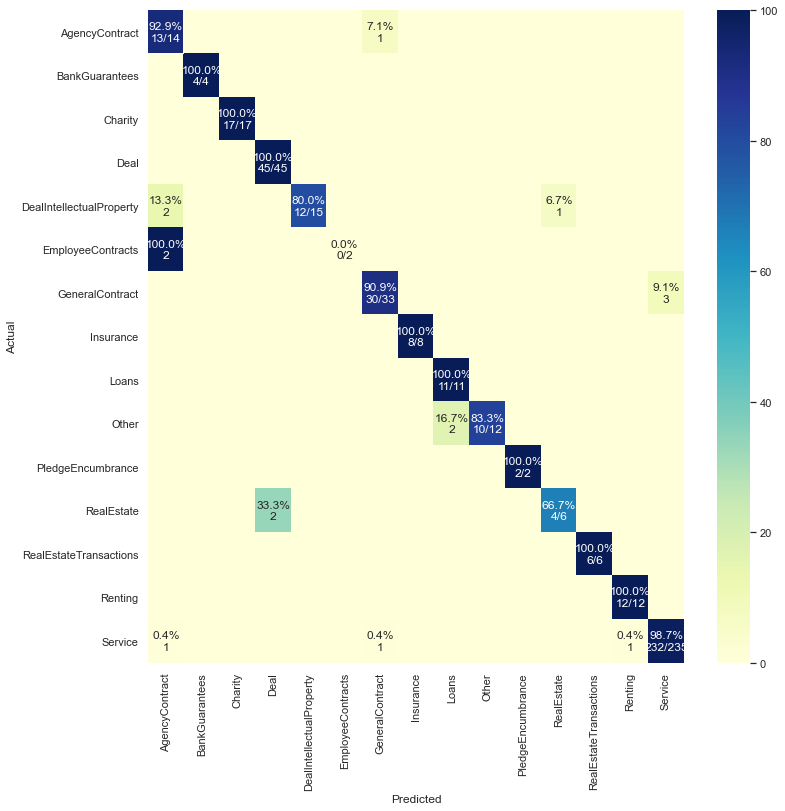

In [43]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


make_report(umodel, ev[~pd.isna(ev['predicted_subj'])])

# Evaluate tags detection

### Contract number validation

In [44]:
tags.fillna('-', inplace=True)
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
logger.info( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags)}%) were detected wronggly')
wrong_numbers[['p-number', 'number']].to_csv('wrong_numbers.csv')
wrong_numbers[['p-number', 'number']].tail(10)


INFO - 2020-07-07 15:18:03,186 - retrain_ipynb - Contract numbers: 70 of 422  (16.587677725118482%) were detected wronggly
INFO - 2020-07-07 15:18:03,186 - retrain_ipynb - Contract numbers: 70 of 422  (16.587677725118482%) were detected wronggly
I0707 15:18:03.186211 4538740160 <ipython-input-44-ecb3a56d0a44>:3] Contract numbers: 70 of 422  (16.587677725118482%) were detected wronggly


,p-number,number
5edbc660da3678279fbcaeac,САХ-17/00000/00016/Р.,САХ-17/00000/00016/Р
5edbc668da3678279fbcaf6e,САХ-17/07000/00073/Р.,САХ-17/07000/00073/Р
5edbc65dda3678279fbcae56,САХ-17/09000/00010/Р.,САХ-17/09000/00010/Р
5edbc66bda3678279fbcafe6,-,САХ-17/09000/00019/Р
5edbc615da3678279fbcadc9,САХ-17/09000/00072/Р.,САХ-17/09000/00072/Р
5edbc65cda3678279fbcae48,-,САХ-17/36000/00120/Р
5edbc66bda3678279fbcafd5,САХ-18/04100/00001/Р аренды,САХ-18/04100/00001/Р
5edbc616da3678279fbcadce,САХ-17/04000/00069/Р,№САХ-17/04000/00069/Р
5edbc665da3678279fbcaf1b,-,№САХ-17/10966/00053/Р
5edbc5afda3678279fbcad6e,ЭЮС-10701/17,№ЭЮС-10701/17


### Contract Org-1 validation

In [45]:
tags.fillna('-', inplace=True)
wrong_orgs1 = tags [ tags['org-1-name'] != tags['p-org-1-name']]
logger.info( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags)}%) were detected incorrectly')

wrong_numbers[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].to_csv('wrong_orgs1.csv')
wrong_orgs1[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(20)

INFO - 2020-07-07 15:18:03,235 - retrain_ipynb - Org-1 name: 30 of 422  (7.109004739336493%) were detected incorrectly
INFO - 2020-07-07 15:18:03,235 - retrain_ipynb - Org-1 name: 30 of 422  (7.109004739336493%) were detected incorrectly
I0707 15:18:03.235099 4538740160 <ipython-input-45-73e30de83334>:3] Org-1 name: 30 of 422  (7.109004739336493%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ
5ee191e12281f29204c52304,гражданин Анцупов А. Н.,гражданин Анцупов А. Н.,Анцупов А. Н.,Газпромнефть-МНПЗ
5ee191e12281f29204c52306,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-ОНПЗ
5ded07184ddc27bcf92dd510,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5de8a3fd1b3453848224a9d5,Спорт,Спорт,Газпромнефть-Транспорт,Спорт
5edbadd1da3678279fbcaa61,пожарного общества,пожарного общества,Адмиралтейское отделение Санкт-Петербургского ...,Газпромнефть-Сахалин
5edbadd2da3678279fbcaa77,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть Научно-Технический Центр,Газпромнефть-Сахалин
5edbadd3da3678279fbcaa8f,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5edbadd8da3678279fbcaaf8,Компания voestalpine Tubulars GmbH & Co,Компания voestalpine Tubulars GmbH & Co,voestalpine Tubulars GmbH & Co KG,Газпромнефть-Сахалин
5edbc616da3678279fbcadce,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Федотова Наталья Александровна


In [46]:
tags.fillna('-', inplace=True)
wrong_orgs2 = tags [ tags['org-2-name'] != tags['p-org-2-name']]
logger.info( f'Org-2 name: {len(wrong_orgs2)} of {len(tags)}  ({100. * len(wrong_orgs2) / len(tags)}%) were detected incorrectly')
wrong_orgs2[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(10)


INFO - 2020-07-07 15:18:03,286 - retrain_ipynb - Org-2 name: 59 of 422  (13.981042654028435%) were detected incorrectly
INFO - 2020-07-07 15:18:03,286 - retrain_ipynb - Org-2 name: 59 of 422  (13.981042654028435%) were detected incorrectly
I0707 15:18:03.286212 4538740160 <ipython-input-46-d3310a2f18e4>:3] Org-2 name: 59 of 422  (13.981042654028435%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5ded4e284ddc27bcf92dd6ce,центр развития ребенка-детский сад № 135 город...,центр развития ребенка-детский сад № 135 город...,Газпромнефть-МНПЗ,центр развития ребенка - детский сад № 135 гор...
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ
5ee191e12281f29204c52304,гражданин Анцупов А. Н.,гражданин Анцупов А. Н.,Анцупов А. Н.,Газпромнефть-МНПЗ
5ee191e12281f29204c52306,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-ОНПЗ
5ee191e12281f29204c5230c,"КЕЙВЕКС""","КЕЙВЕКС""",Газпромнефть-МНПЗ,КЕЙВЕКС
5ded004b4ddc27bcf92dd461,"Страховое общество газовой промышленности""","Страховое общество газовой промышленности""",Газпромнефть-Сахалин,Страховое общество газовой промышленности
5ded004e4ddc27bcf92dd478,Геологический институт Российской академии наук (,Геологический институт Российской академии наук (,Газпромнефть-Сахалин,Геологический институт Российской академии наук
5ded07184ddc27bcf92dd510,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5ded07194ddc27bcf92dd5ed,Институт промышленной безопасности,Институт промышленной безопасности,Газпромнефть-Сахалин,ИПБОТСП
5dee80604ddc27bcf92dd88e,гражданин Трухан Александр,гражданин Трухан Александр,Газпромнефть-СМ,Трухан Александр Михайлович


In [47]:

wrong_aliases1 = tags [ tags['org-1-alias'] != tags['p-org-1-alias']]
logger.info( f'Alias-1: {len(wrong_aliases1)} of {len(tags)}  ({100. * len(wrong_aliases1) / len(tags)}%) were detected incorrectly')
# wrong_orgs[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

wrong_aliases2 = tags [ tags['org-2-alias'] != tags['p-org-2-alias']]
logger.info( f'Alias-2: {len(wrong_aliases2)} of {len(tags)}  ({100. * len(wrong_aliases2) / len(tags)}%) were detected incorrectly')
wrong_aliases2[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

INFO - 2020-07-07 15:18:03,317 - retrain_ipynb - Alias-1: 31 of 422  (7.345971563981043%) were detected incorrectly
INFO - 2020-07-07 15:18:03,317 - retrain_ipynb - Alias-1: 31 of 422  (7.345971563981043%) were detected incorrectly
I0707 15:18:03.317647 4538740160 <ipython-input-47-9e27cec1ce8a>:2] Alias-1: 31 of 422  (7.345971563981043%) were detected incorrectly
INFO - 2020-07-07 15:18:03,323 - retrain_ipynb - Alias-2: 44 of 422  (10.42654028436019%) were detected incorrectly
INFO - 2020-07-07 15:18:03,323 - retrain_ipynb - Alias-2: 44 of 422  (10.42654028436019%) were detected incorrectly
I0707 15:18:03.323843 4538740160 <ipython-input-47-9e27cec1ce8a>:6] Alias-2: 44 of 422  (10.42654028436019%) were detected incorrectly


,p-org-1-alias,p-org-2-alias,org-1-alias,org-2-alias
5ded4e284ddc27bcf92dd6ce,Даритель,-,Даритель,Одаряемый
5e58df7823869ee435388239,-,Залогодатель,Залогодатель,Залогодержатель
5df7a66b200a3f4d0fad7874,-,-,ОБЩЕСТВО,ХРАНТРАНСНЕФТЬ
5e5de70d01c6c73c19eebd4a,Застройщик,подрядчик,Генеральный подрядчик,Застройщик
5ded06fa4ddc27bcf92dd4b9,-,-,Абонент,Оператор
5ded07184ddc27bcf92dd50e,Заказчик,Исполнитель,Заказчик,-
5dee80604ddc27bcf92dd88e,Общество,директор,Генеральный директор,Общество
5ee8c456c28b75807f3dabe3,Заказчик,Подрядчик,Заказчик,-
5ee832322281f29204c52c2c,Покупатель,-,Покупатель,Поставщик
5dece9bf4ddc27bcf92dd418,ЛИЦЕНЗИАР,-,ЛИЦЕНЗИАР,ЛИЦЕНЗИАТ


In [48]:
wrong_types1 = tags [ tags['org-1-type'] != tags['p-org-1-type']]
wrong_types2 = tags [ tags['org-2-type'] != tags['p-org-2-type']]

In [49]:
from collections import Counter

counter = Counter()
for i in wrong_orgs1.index:
  counter[i]+=1
for i in wrong_orgs2.index:
  counter[i]+=1
for i in wrong_types1.index:
  counter[i]+=1
for i in wrong_types2.index:
  counter[i]+=1
for i in wrong_numbers.index:
  counter[i]+=1
for i in wrong_aliases1.index:
  counter[i]+=1
for i in wrong_aliases2.index:
  counter[i]+=1

for i in errors_report.index:#wrong subjects
  counter[i]+=1

print(counter.most_common()[0][0])
print(len(counter))

5eea2797c28b75807f3dac5d
196


In [50]:
umtm.stats['errors']=0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

I0707 15:18:03.558223 4538740160 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 670
I0707 15:18:03.785938 4538740160 retrain_contract_uber_model.py:283] docs in meta: 670
I0707 15:18:03.809463 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 670
I0707 15:18:03.834202 4538740160 retrain_contract_uber_model.py:283] docs in meta: 670
I0707 15:18:03.843047 4538740160 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 670


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,errors,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-07-02 13:15:11.351819,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.22.1,2020-06-30 21:27:54.865,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,0,4.347162,2.747869
5eea27adc28b75807f3dae66,2020-07-02 13:15:53.723054,GeneralContract,Заказчик/ЗАКАЗЧИК,Подрядчик/ПОДРЯДЧИК/ЕРС-Подрядчик,8a9ce8cea53e54a03caa5c252ad2bb7b,1.22.1,2020-06-30 22:19:35.189,2.807709e+10,24.058220,21847.0,0.955438,2020-06-19 05:39:50.512,True,0,3.090551,2.663065
5eea279dc28b75807f3daccb,2020-07-02 13:15:11.091052,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.22.1,2020-06-30 21:27:51.400,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,0,3.768257,2.381939
5eea27b1c28b75807f3daec7,2020-07-02 13:16:00.973259,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.22.1,2020-06-30 22:27:48.787,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225,True,0,2.736872,2.358307
5dfa6a938d25a1ac83160bf1,2020-07-02 13:12:36.791502,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759,True,0,1.554537,2.357114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc65dda3678279fbcae68,2020-07-02 13:13:55.965525,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.22.1,2020-06-30 20:08:00.030,NaN,NaN,NaN,0.994054,NaT,True,0,0.095753,0.145188
5edbc5a9da3678279fbcad29,2020-07-02 13:13:45.263897,Service,,,4e9bbffec18a5ce4417ea091ed871979,1.22.1,2020-06-30 19:49:34.496,NaN,NaN,NaN,0.998208,NaT,True,0,0.095753,0.145188
5edbadd7da3678279fbcaabd,2020-07-02 13:13:38.675092,Service,Заказчик,Исполнитель,f41c6fe54622dc70f276d07d7a1f86a1,1.22.1,2020-06-30 19:40:11.446,NaN,NaN,NaN,0.991027,NaT,True,0,0.095753,0.145188


## Single doc eval

In [51]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

I0707 15:18:03.966940 4538740160 <ipython-input-51-1b76c9271c48>:14] fetching 5eea2797c28b75807f3dac5d


SAMPLE_DOC_ID: 5eea2797c28b75807f3dac5d


/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [52]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

2 uber_detection_model_005_1_1
Subject: (<ContractSubject.AgencyContract: 21>, 0.5716797709465027, 21)


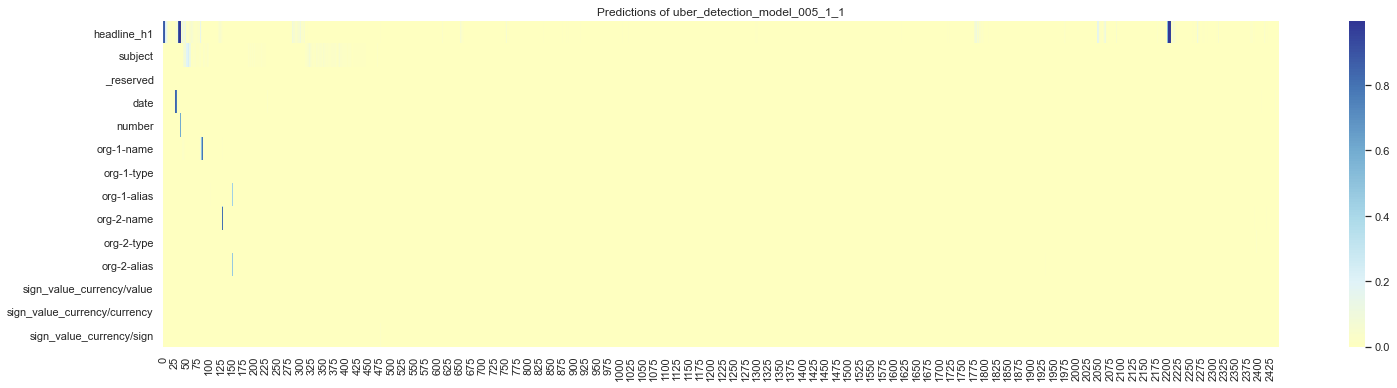

In [53]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  print(t.upper(), spans)
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))
